In [1]:
import msprime
import numpy as np
from IPython.display import SVG
%load_ext rpy2.ipython
# %reload_ext rpy2.ipython

# A state space model for mutations along two genomes

## State space model: Simonsen-Churchill framework

This is the full transition rate matrix:

In [2]:
%%R

ARGRateM_slow <- function(rho){
  RateM <-
    matrix(c(0,rho,0,0,0,0,0,1,
             1,0,rho/2,1,1,0,0,0,             
             0,4,0,0,0,1,1,0,
             0,0,0,0,0,rho/2,0,1,
             0,0,0,0,0,0,rho/2,1,
             0,0,0,2,0,0,0,1,
             0,0,0,0,2,0,0,1,
             0,0,0,0,0,0,0,0),nrow=8,ncol=8,byrow=TRUE)
  ## Get diagonals right (must sum to 0)
  for (rw in 1:8){
    RateM[rw,rw] <- -sum(RateM[rw,])
  }
  return(RateM)
}

ARGRateMat_slow <- ARGRateM_slow(0.1*2)

ARGRateMat_slow

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,] -1.2  0.2  0.0  0.0  0.0  0.0  0.0    1
[2,]  1.0 -3.1  0.1  1.0  1.0  0.0  0.0    0
[3,]  0.0  4.0 -6.0  0.0  0.0  1.0  1.0    0
[4,]  0.0  0.0  0.0 -1.1  0.0  0.1  0.0    1
[5,]  0.0  0.0  0.0  0.0 -1.1  0.0  0.1    1
[6,]  0.0  0.0  0.0  2.0  0.0 -3.0  0.0    1
[7,]  0.0  0.0  0.0  0.0  2.0  0.0 -3.0    1
[8,]  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0


This is the fast version of the function above, where some of the states are removed from the chain if we are only interested in the heights:

In [3]:
%%R

ARGRateM <- function(rho){
  RateM <-
    matrix(
        c(-(1+rho),        rho,     0, 1,
                 1, -(3+rho/2), rho/2, 2,
                 0,          4,    -6, 2, 
                 0,          0,     0, 0),
        nrow=4,ncol=4,byrow=TRUE)
}

ARGRateMat <- ARGRateM(0.1*2)

ARGRateMat

     [,1] [,2] [,3] [,4]
[1,] -1.2  0.2  0.0    1
[2,]  1.0 -3.1  0.1    2
[3,]  0.0  4.0 -6.0    2
[4,]  0.0  0.0  0.0    0


Equation (1) and figure 2A can be coded this way:

In [4]:
%%R


library("tidyverse")
library('expm')
library('reshape2')
library('patchwork')

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘expm’


R[write to console]: The following object is masked from ‘package:Matrix’:

    expm


R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths




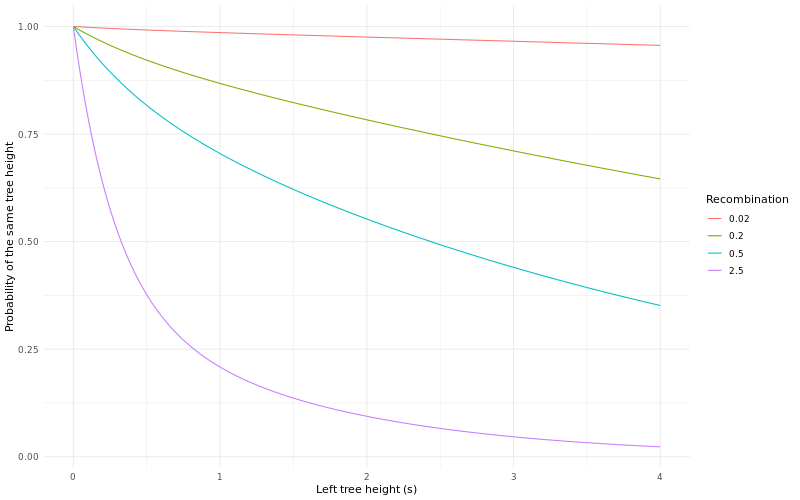

In [5]:
%%R -w 800 -h 500



n <- 1000
s <- seq(from=0.001, to=4.0,length=n)

# Table with the values
tab_dat <- expand.grid(
        s_tib = s, 
        rho_tib = c(0.02, 0.2, 0.5, 2.5)) %>%
    # For each row
    rowwise() %>%
    # Get the probablity by applying eq. (1)
    mutate(
        den = (exp(s_tib)*expm(ARGRateM(rho_tib)*s_tib)[1,1])) %>%
    ungroup() %>%
    mutate(
        Recombination = as.character(rho_tib)
    )
    
    
tab_dat %>% 
    ggplot() + 
    geom_line(aes(s_tib, den, color = Recombination)) +
    theme_minimal() +
    ylab('Probability of the same tree height') +
    xlab('Left tree height (s)')
    

The following code is for reproducing figure 2B from equation (2):

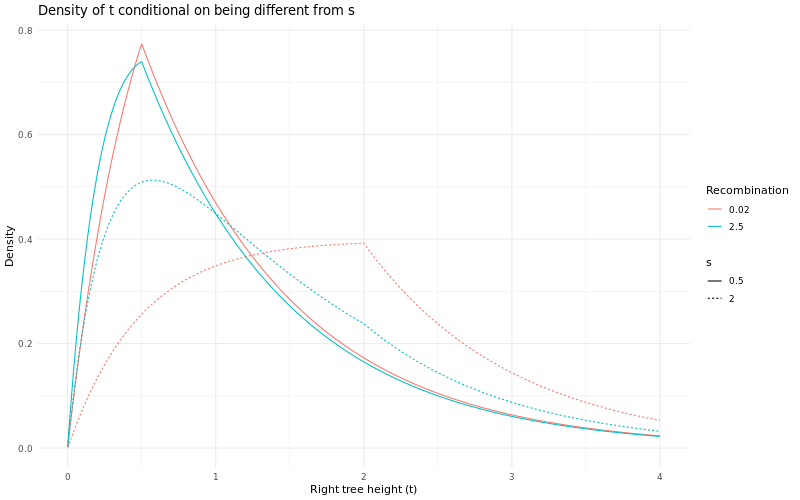

In [6]:
%%R -w 800 -h 500

# This function is the variable part
# within equation (2), this is, the 
# numerator
ARGTrns <- function(rho, s, t){
    ARGRateMat <- ARGRateM(rho)
    expm.s <- expm(ARGRateMat*s)
    exp(-(t-s))*(expm.s[1,2]+expm.s[1,3])
    
}

# Define the data frame with array of t
# and different values of rho and base s
n <- 1000
t <- seq(from=0.001, to=4.0,length=n)  
tab_dat <- expand.grid(
        t_tib = t, 
        rho_tib = c(0.02, 2.5), 
        s_tib = c(0.5, 2)) %>% 
    # For each row
    rowwise() %>%
    mutate(
        # Calculate numerator
        den = 
            ifelse(
                t_tib > s_tib, 
                ARGTrns(rho_tib, s_tib, t_tib),
                ARGTrns(rho_tib, t_tib, s_tib)),
        # Divide by denominator
        den = 
            den/(exp(-s_tib)-expm(ARGRateM(rho_tib)*s_tib)[1,1])) %>%
    ungroup() %>%
    mutate(
        Recombination = as.character(rho_tib),
        s = as.character(s_tib)
    )
    
tab_dat %>% 
    ggplot() + 
    geom_line(aes(t_tib, den, color = Recombination, linetype = s)) +
    theme_minimal() +
    ylab('Density') +
    xlab('Right tree height (t)') +
    ggtitle('Density of t conditional on being different from s')



## Time discretization: setting up the finite state HMM

In [7]:
%%R

FastTransMat <- function(tm,rho){
  # This produces a rate matrix which has an additional state,
  # number 4, which represents states 4, 5, 6 and 7 of the 
  # 'slow' matrix. Thus, state 5 corresponds to the absorbing
  # state, i.e. state 8 in the 'slow' matrix. 
  rate_mat <- matrix(c(-(1+rho),rho,0,0,1,
                              1,-(3+rho/2),rho/2,2,0,             
                              0,4,-6,2,0,
                              0,0,0,-1,1,
                              0,0,0,0,0),
                            nrow=5,ncol=5,byrow=TRUE)
  nInt <- length(tm) ## Number of intervals
  tm0 <- c(0,tm) ## tm0 is tm with time 0 added
  ##-------------------------------------
  JointMat <- matrix(0,nrow=nInt,ncol=nInt) ## Joint prb matrix
  for (j in 1:(nInt-1)){  ## Left state
    for (k in j:nInt){  ## Right state
      if (j<k){
        JointMat[j,k] <-
          expm(tm0[j]*rate_mat)[1,1:3]%*%
          expm((tm[j]-tm0[j])*rate_mat)[1:3,4]*
          exp(-(tm0[k]-tm[j]))*
          # which is the same as 
          # expm((tm0[k]-tm[j])*rate_mat)[4,4]*0.5*
            (1-exp(-(tm[k]-tm0[k])))*0.5
            # which is the same as 
            # expm((tm[k]-tm0[k])*rate_mat)[4,5]
            # but because expm can't handle infinity, 
            # we need to do a workaround 
        # Symmetrize
        JointMat[k,j] <- JointMat[j,k]
      }
      if (j==k){
        JointMat[j,k] <-
          expm(tm0[j]*rate_mat)[1,1:3]%*%
          expm((tm[j]-tm0[j])*rate_mat)[1:3,5]
      }
    }
  }
  ## Final entry
  JointMat[nInt,nInt] <- sum(expm(tm0[nInt]*rate_mat)[1,1:3])
  ## Again: expm can't handle infinity, and state 8 is absorbing
  ## Transition matrix 
  TransMat <- JointMat/rowSums(JointMat)
  return(TransMat)
}


In [8]:
%%R


calc_tm <- function(nInt) -log(1-1:(nInt)/nInt)

nInt <- 20
tm <- calc_tm(nInt)
rho <- 0.1*2
TransM <- FastTransMat(tm, rho)

print(tm)
print(diag(TransM))
print(length(tm))
length(diag(TransM))

 [1] 0.05129329 0.10536052 0.16251893 0.22314355 0.28768207 0.35667494
 [7] 0.43078292 0.51082562 0.59783700 0.69314718 0.79850770 0.91629073
[13] 1.04982212 1.20397280 1.38629436 1.60943791 1.89711998 2.30258509
[19] 2.99573227        Inf
 [1] 0.9951841 0.9857877 0.9764774 0.9672275 0.9580089 0.9487883 0.9395264
 [8] 0.9301772 0.9206851 0.9109823 0.9009846 0.8905853 0.8796464 0.8679849
[15] 0.8553512 0.8413964 0.8256254 0.8073779 0.7864068 0.7864068
[1] 20
[1] 20


# Simulation of the ancestral history

We can now simulate the ancestral history of 2 haploid samples under the coalescent with recombination using msprime.

In [9]:
ts = msprime.sim_ancestry(
    samples=2,
    recombination_rate=0.1,
    sequence_length=100_000,
    random_seed = 237244,
    population_size = 1,
    ploidy = 1
)
# Visualise the simulated ancestral history.
# SVG(ts.draw_svg())

We can now calculate the number of sites belonging to each tree inferred by msprime, together with the number of transitions between the trees: 

In [10]:
# Create a matrix with 0 values
trans_mat = np.zeros((ts.num_nodes-2, ts.num_nodes-2))
first = True
# For each tree
for tree in ts.trees():
    # If not the first iteration
    if not first:
        # Count transition
        trans_mat[n_prev, tree.root-2] += 1
    # Update previous iteration counter
    n_prev = tree.root-2
    first = False
    # Add number of sites in that tree to diagonal
    trans_mat[tree.root-2, tree.root-2] += tree.span-1

In [11]:
trans_mat[1:10, 1:10]

array([[123.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 250.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., 691.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., 921.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  96.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 184.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 423.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 175.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 167.]])

We can also recover the height  each tree in the simulation:

In [12]:
tree_heights = ts.tables.nodes[2:].asdict()['time'].tolist()
tree_heights[1:10]

[0.008786283382179225,
 0.0117159987718138,
 0.01488176909292936,
 0.015597224113702138,
 0.017424383640293438,
 0.02362972727746996,
 0.02605123781021025,
 0.026404192465305693,
 0.03161535997214476]

We now have all the ingredients to simplify the simulated transition matrix based on the cutpoints defined by the discretized times:

In [13]:
%%R -i trans_mat -i tree_heights

# Import the tre heights as vector
tree_heights <- unlist(tree_heights)

# Create vector for assigning each simulated tree to an interval
cut_vec <- cut(tree_heights, breaks = c(0,tm), labels = FALSE, right = FALSE)

# Create empty matrix with the right dimensions
discrete_mat <- matrix(0, length(tm), length(tm))

# For each interval
for (i in 1:length(tm)) {
    # Save indices of trees belonging to interval i
    vec_idx_i <- which(cut_vec == i)
        # For each interval
        for (j in 1:length(tm)) {
            # Save indices of trees belonging to interval j
            vec_idx_j <- which(cut_vec == j)
            # If both indices are non-empty
            if ((length(vec_idx_i) != 0) & (length(vec_idx_j) != 0)) {
                # Save sum of the sub-matrix
                discrete_mat[i, j] <- 
                    sum(trans_mat[vec_idx_i, vec_idx_j])   
        }
    }
}


print(discrete_mat[1:10, 1:10])

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
 [1,] 5328    2    2    0    0    2    0    0    1     0
 [2,]    1 4471    6    3    3    1    0    1    3     5
 [3,]    2    2 4726    9    6    5    3    3    6     7
 [4,]    1    7    6 4992    4   12   14    7   11     4
 [5,]    1    5    5   10 4250    9   11   10    6    10
 [6,]    3    4    8    3   12 4512   15   20   11    19
 [7,]    0    6    6    8    8   16 4197   15   19    21
 [8,]    3    5    4   11   12   21   23 4440   21    14
 [9,]    1    3    2   11   11   11   18   22 4606    27
[10,]    3    4    5    5   11   19   24   22   26  4616


In order to get the probabilities, we can divide by the total number per row. In theory, this should be the same as dividing it by the total number per column, but in the simulations there might be some differences due to the matrix not being completely symmetric. Just in case, we can compute the column sums after re-scaling by the row sums to check whether they are roughly the same:

In [14]:
%%R

# Divide by the row sums
discrete_mat <- discrete_mat/rowSums(discrete_mat)

# Check that  rowSums and colSums are roughly equal
print(rowSums(discrete_mat))
print(colSums(discrete_mat))

 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [1] 1.0003467 0.9988586 0.9993006 1.0011192 0.9948545 0.9972314 0.9925584
 [8] 0.9960352 0.9988634 1.0011439 1.0006542 0.9877376 1.0101726 0.9958259
[15] 1.0035787 0.9985555 1.0105291 1.0136616 1.0006253 0.9983476


We can start comparing the theoretical and the simulated matrices. First, we can compare the diagonal values. 

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



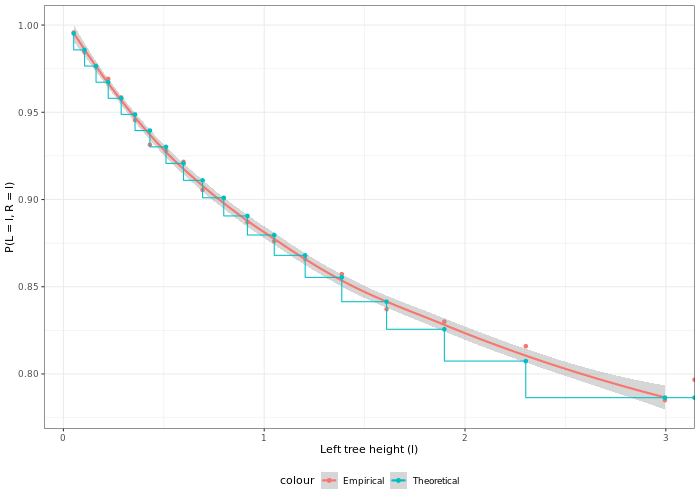

In [15]:
%%R  -w 700 -h 500

ggplot() +
    geom_point(aes(tm, diag(discrete_mat), color = 'Empirical')) +
    geom_smooth(aes(tm, diag(discrete_mat), color = 'Empirical')) +
    geom_point(aes(tm, diag(TransM), color = 'Theoretical')) +
    geom_step(aes(tm, diag(TransM), color = 'Theoretical'), direction="vh") +
    theme_bw() +
    theme(legend.position = 'bottom') +
    ylab(paste0('P(L = l, R = l)')) +
    xlab(paste0('Left tree height (l)'))
    


Note that the x values for the points are the upper boundaries in tree height of each of the intervals. 

We can also compute the probability given a certain interval. For example, we can plot the probabilities for when the left tree height is in the interval number 10:

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



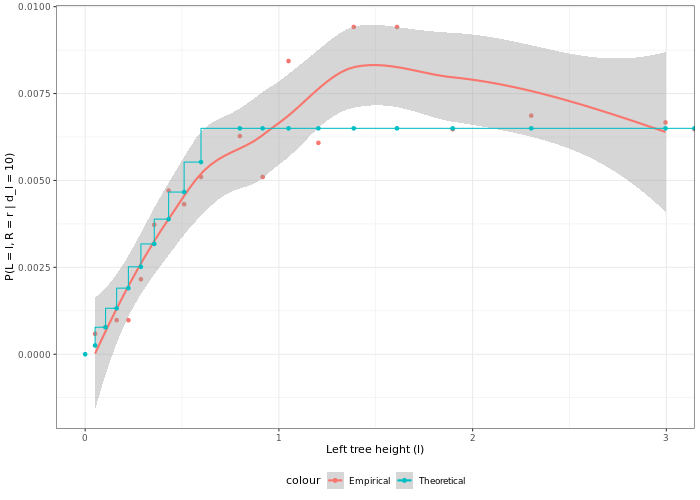

In [16]:
%%R  -w 700 -h 500

interval <- 10

ggplot() +
    geom_point(aes(tm[-interval], discrete_mat[interval,][-interval], color = 'Empirical')) +
    geom_smooth(aes(tm[-interval], discrete_mat[interval,][-interval], color = 'Empirical')) +
    geom_step(aes(tm[-interval], TransM[interval,][-interval], color = 'Theoretical'), direction="vh") +
    geom_point(aes(c(0, tm[-interval]), c(0, TransM[interval,][-interval]), color = 'Theoretical')) +
    theme_bw() +
    theme(legend.position = 'bottom') +
    ylab(paste0('P(L = l, R = r | d_l = ', interval, ')')) +
    xlab(paste0('Left tree height (l)'))
    


Note that the x values for the points are the upper boundaries in tree height of each of the intervals. Also, the y value corresponding to the analyzed interval is also removed for simplicity. 

We can also compare the matrices as a whole by plotting them side by side. The color scale is log-transformed to be able to see the values off the diagonal. Also, those values in the simulated matrix with a probability of 0 (because they were not found) are defaulted to the lowest color in the scale:

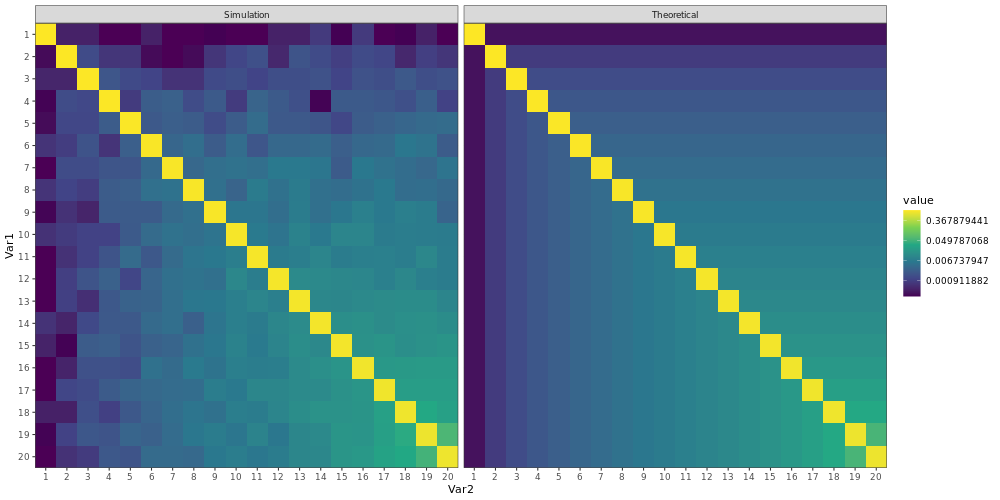

In [17]:
%%R  -w 1000 -h 500

melt(discrete_mat) %>% 
    mutate(type = 'Simulation') %>%
    bind_rows(
        mutate(
            melt(TransM),
            type = 'Theoretical'
        )
    ) %>%
    ggplot() +
    geom_tile(aes(Var2, Var1, fill = value)) +
    scale_y_reverse(breaks = 1:20, expand = c(0, 0)) +
    scale_x_continuous(breaks = 1:20, expand = c(0, 0)) +
    facet_wrap(~type) +
    theme_bw() +
    scale_fill_viridis_c(
        trans = 'log', 
        na.value = hcl.colors(1)
    )



# The mutational process

After proving that the simulated values for the transition matrix match the theoretical expectation, we can now move on to analyzing the mutational process. We can calculate the probability for a mutation in a given discretized interval using the following:

In [18]:
%%R


calc_p_mut <- function(tm, tht) {
    tm_1 <- c(0, tm[1:(length(tm)-1)])
    prob_mutation <- rep(NA, length(tm))
    for (i in 1:length(tm)){
        prob_mutation[i] <- 1-exp(-tht*tm_1[i])*(1-exp(-(1+tht)*(tm[i]-tm_1[i])))/(1-exp(-(tm[i]-tm_1[i])))/(1+tht)
    }
    prob_mutation
}

prob_mut <- calc_p_mut(tm, tht = 0.01*2)

prob_mut

 [1] 0.000508375 0.001560399 0.002669725 0.003843035 0.005088256 0.006414894
 [7] 0.007834484 0.009361210 0.011012794 0.012811774 0.014787442 0.016978844
[13] 0.019439687 0.022246773 0.025515579 0.029431770 0.034323571 0.040862732
[19] 0.050842891 0.076622627


We are now ready to simulate the mutational process on top of the tree collection previously simulated using msprime:

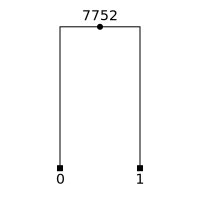

In [19]:
mutated_ts = msprime.sim_mutations(
    ts,
    rate = 0.01,
    model = 'infinite_alleles'
)

SVG(mutated_ts.first().draw_svg())

We can now recover the number of mutations that happened in each of the trees:

In [20]:
# Create a matrix with 0 values
mut_mat = np.zeros((mutated_ts.num_nodes-2, 2))
first = True
# For each tree
for tree in mutated_ts.trees():
    # Save the number of positions in the tree
    mut_mat[tree.root-2, 0] += tree.span
    # save the number of mutations
    mut_mat[tree.root-2, 1] += tree.num_mutations
    
mut_mat

array([[679.,   0.],
       [124.,   0.],
       [251.,   0.],
       ...,
       [  2.,   4.],
       [  2.,   0.],
       [  2.,   1.]])

We can now calculate the number of mutations for each of the discretized intervals:

In [21]:
%%R -i mut_mat

(mutat_tib <- as_tibble(mut_mat) %>%
    # add the interval associated to each tree
    mutate(
        bin = cut_vec
    ) %>%
    # group by each interval
    group_by(bin) %>%
    # calculate the number of sites 
    # and mutations per interval
    summarize(
        sites = sum(V1),
        mutations = sum(V2),
        p_obs = mutations/sites
    ) %>%
    # add the expected probability and height
    mutate(
        p_exp = prob_mut,
        height = tm[bin]
    ))

# A tibble: 20 × 6
     bin sites mutations    p_obs    p_exp   height
   <int> <dbl>     <dbl>    <dbl>    <dbl>    <dbl>
 1     1  5351         3 0.000561 0.000508   0.0513
 2     2  4542         3 0.000661 0.00156    0.105 
 3     3  4841         8 0.00165  0.00267    0.163 
 4     4  5151        15 0.00291  0.00384    0.223 
 5     5  4434        21 0.00474  0.00509    0.288 
 6     6  4772        38 0.00796  0.00641    0.357 
 7     7  4506        36 0.00799  0.00783    0.431 
 8     8  4786        51 0.0107   0.00936    0.511 
 9     9  4998        58 0.0116   0.0110     0.598 
10    10  5098        70 0.0137   0.0128     0.693 
11    11  5093        71 0.0139   0.0148     0.799 
12    12  4553        74 0.0163   0.0170     0.916 
13    13  5457        98 0.0180   0.0194     1.05  
14    14  4943       112 0.0227   0.0222     1.20  
15    15  5238       150 0.0286   0.0255     1.39  
16    16  5066       138 0.0272   0.0294     1.61  
17    17  5423       203 0.0374   0.0343     

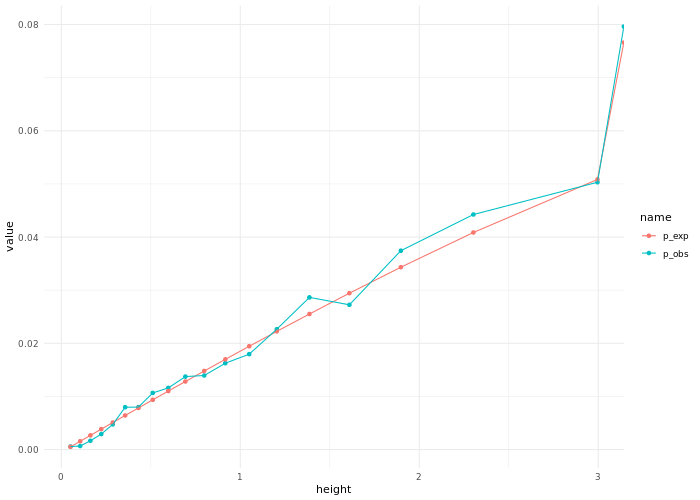

In [22]:
%%R -w 700 -h 500

mutat_tib %>%    
    pivot_longer(starts_with("p_")) %>%
    ggplot() +
        geom_point(aes(height, value, color = name)) +
        geom_line(aes(height, value, color = name)) +
        theme_minimal()

# Hidden Markov model

We can think of the ancestral history with recombination and mutation as a hidden Markov model (HMM), where the discretized tree heights are the hidden states and the mutations are the emitted observations. We now have all the ingredients for building a hidden Markov model:

* The initial probabilities.
* The transition probability matrix will be the transition matrix for the discretized times, which is dependant on rho.
* The emission probability matrix will be the probability of observing (or not) a mutation, which is dependant on both rho and theta.

The following code can be used to calculate the logarithmic forward likelihood given the initial probabilities, the transition probabilities, the emission probabilities and a vector of the observed mutations:

In [23]:
%%R

logFrwdLikFct <- function(InitProb,TransProb,EndProb,EmisProb,ObsSeq){
  # Number of observations
  len <- length(ObsSeq)
  # Number of hidden states
  nHS <- nrow(TransProb)
  # Define logForwardLik
  logForwardLik <- matrix(0,nrow=len,ncol=nHS)
  # Start condition
  logForwardLik[1,] <- log(InitProb*EmisProb[,ObsSeq[1]])
  # Determine logForwardLik by recursion 
  for(k in 2:len){
    a <- max(logForwardLik[k-1,])
    # Calculate the loglik of current iteration
    logForwardLik[k,] <- 
      log(colSums(
          (exp(logForwardLik[k-1,]-a)%*%TransProb)*EmisProb[,ObsSeq[k]]
      ))+a
  }  
  a <- max(logForwardLik[len,])
  logForwardLikVal <- log(sum(EndProb*exp(logForwardLik[len,]-a)))+a
  return(logForwardLikVal)
}

The above code has a little trick to improve numerical stability. For each iteration, it substracts the maximum loglik value of the previous iteration to the loglik values of the previous iteration before exponentiating them. After performing all the computations, we go back to the logarithm and we will add the value we substracted earlier.

In order to run the forward algorithm, we should calculate the observed mutations first:

In [24]:
mut_pos = []
for variant in mutated_ts.variants():
    mut_pos.append(int(variant.position))
mut_pos[1:10]

[50, 128, 150, 163, 188, 191, 238, 252, 271]

We can create a binary vector, where a 1 means that there is a mutation in that position, and a 0 indicates a lack of mutation:

In [25]:
mut_pos_bin = np.zeros(int(mutated_ts.sequence_length), dtype=np.int32)
for i in range(int(mutated_ts.sequence_length)):
    if i in mut_pos:
        mut_pos_bin[i] = 1
    else:
        mut_pos_bin[i] = 0
mut_pos_bin[1:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's now run the forward algorithm over a grid of rho values and save the loglik associated to them. In order to do so, we have to specify a fixed value of theta:

In [26]:
%%R -i mut_pos_bin

tht <- 0.01*2
rho <- 0.1*2

rho.v <- seq(from=0.10,to=0.30,by=0.01)
logL_rho.v <- rep(0,len=length(rho.v))

for (i in 1:length(rho.v)) {
    initial <- (1:nInt)/nInt
    transition <- FastTransMat(tm, rho.v[i])
    emission <- matrix(c(1-calc_p_mut(tm, tht),calc_p_mut(tm, tht)),ncol=2,byrow=FALSE)
    logL_rho.v[i] <- logFrwdLikFct(initial, transition, initial, emission, mut_pos_bin+1)
    print(paste0("rho=",rho.v[i],", log likelihood=",logL_rho.v[i]))
}



[1] "rho=0.1, log likelihood=-9783.09787260693"
[1] "rho=0.11, log likelihood=-9781.15409646348"
[1] "rho=0.12, log likelihood=-9779.58700613519"
[1] "rho=0.13, log likelihood=-9778.32622868779"
[1] "rho=0.14, log likelihood=-9777.31758095281"
[1] "rho=0.15, log likelihood=-9776.51870744814"
[1] "rho=0.16, log likelihood=-9775.89604413114"
[1] "rho=0.17, log likelihood=-9775.4226649183"
[1] "rho=0.18, log likelihood=-9775.07672732013"
[1] "rho=0.19, log likelihood=-9774.84033218847"
[1] "rho=0.2, log likelihood=-9774.69867474627"
[1] "rho=0.21, log likelihood=-9774.63940391821"
[1] "rho=0.22, log likelihood=-9774.6521329242"
[1] "rho=0.23, log likelihood=-9774.72806127932"
[1] "rho=0.24, log likelihood=-9774.85967990137"
[1] "rho=0.25, log likelihood=-9775.04053894079"
[1] "rho=0.26, log likelihood=-9775.26506344745"
[1] "rho=0.27, log likelihood=-9775.52840587138"
[1] "rho=0.28, log likelihood=-9775.82632717714"
[1] "rho=0.29, log likelihood=-9776.15510036527"
[1] "rho=0.3, log likeli

Instead of defining a grid of values ourselves, we can simply use the `optimize` function in R to calculate the value with the largest loglik:

In [27]:
%%R

optim_rho <- function(rho) {
    initial <- (1:nInt)/nInt
    transition <- FastTransMat(tm, rho)
    emission <- matrix(c(1-calc_p_mut(tm, tht),calc_p_mut(tm, tht)),ncol=2,byrow=FALSE)
    logFrwdLikFct(initial, transition, initial, emission, mut_pos_bin+1)
}

max_lik_rho <- optimize(optim_rho, c(0.1, 0.3), maximum = TRUE)

max_lik_rho

$maximum
[1] 0.2130881

$objective
[1] -9774.636



When plotting these results together, we can see that the optimization worked quite well:

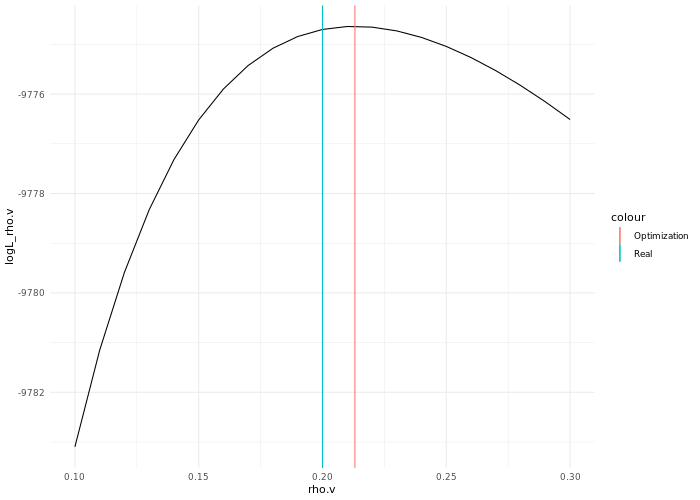

In [28]:
%%R -w 700 -h 500

ggplot() +
    geom_line(aes(rho.v, logL_rho.v)) +
    geom_vline(aes(xintercept = rho, color = 'Real')) +
    geom_vline(aes(xintercept = max_lik_rho$maximum, color = 'Optimization')) +
    theme_minimal()

Additionally, we can also optimize for theta by choosing a fixed value for rho:

In [29]:
%%R -i mut_pos_bin

tht <- 0.01*2
rho <- 0.1*2

tht.v <- seq(from=0.01,to=0.03,by=0.001)
logL_tht.v <- rep(0,len=length(tht.v))

for (i in 1:length(tht.v)) {
    initial <- (1:nInt)/nInt
    transition <- FastTransMat(tm, rho)
    emission <- matrix(c(1-calc_p_mut(tm, tht.v[i]),calc_p_mut(tm, tht.v[i])),ncol=2,byrow=FALSE)
    logL_tht.v[i] <- logFrwdLikFct(initial, transition, initial, emission, mut_pos_bin+1)
    print(paste0("tht=",tht.v[i],", log likelihood=",logL_tht.v[i]))
}



[1] "tht=0.01, log likelihood=-10082.7376516111"
[1] "tht=0.011, log likelihood=-10008.2608992905"
[1] "tht=0.012, log likelihood=-9948.4982697066"
[1] "tht=0.013, log likelihood=-9900.79764436626"
[1] "tht=0.014, log likelihood=-9863.10378509966"
[1] "tht=0.015, log likelihood=-9833.79262674388"
[1] "tht=0.016, log likelihood=-9811.55935274522"
[1] "tht=0.017, log likelihood=-9795.34062853564"
[1] "tht=0.018, log likelihood=-9784.25922761956"
[1] "tht=0.019, log likelihood=-9777.58373883752"
[1] "tht=0.02, log likelihood=-9774.69867474627"
[1] "tht=0.021, log likelihood=-9775.08191041951"
[1] "tht=0.022, log likelihood=-9778.2873924757"
[1] "tht=0.023, log likelihood=-9783.93170627021"
[1] "tht=0.024, log likelihood=-9791.68351304904"
[1] "tht=0.025, log likelihood=-9801.25515143443"
[1] "tht=0.026, log likelihood=-9812.39588972997"
[1] "tht=0.027, log likelihood=-9824.88644891157"
[1] "tht=0.028, log likelihood=-9838.53451099319"
[1] "tht=0.029, log likelihood=-9853.17099673237"
[1] 

In [30]:
%%R

optim_tht <- function(tht) {
    initial <- (1:nInt)/nInt
    transition <- FastTransMat(tm, rho)
    emission <- matrix(c(1-calc_p_mut(tm, tht),calc_p_mut(tm, tht)),ncol=2,byrow=FALSE)
    logFrwdLikFct(initial, transition, initial, emission, mut_pos_bin+1)
}

max_lik_tht <- optimize(optim_tht, c(0.01, 0.03), maximum = TRUE)

max_lik_tht

$maximum
[1] 0.02038873

$objective
[1] -9774.485



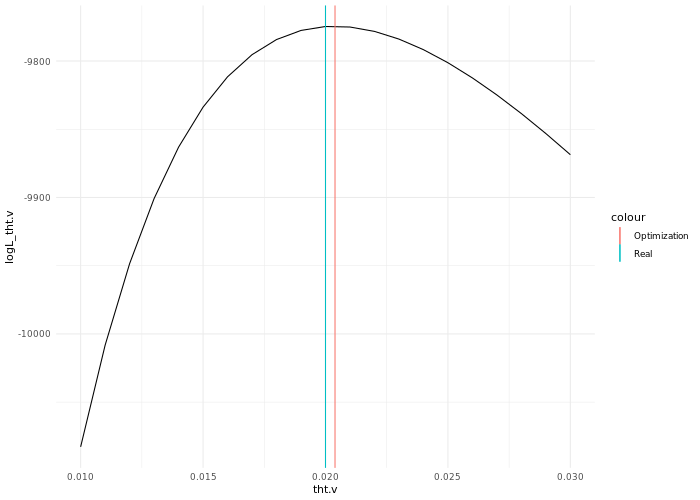

In [31]:
%%R -w 700 -h 500

ggplot() +
    geom_line(aes(tht.v, logL_tht.v)) +
    geom_vline(aes(xintercept = tht, color = 'Real')) +
    geom_vline(aes(xintercept = max_lik_tht$maximum, color = 'Optimization')) +
    theme_minimal()